<a href="https://www.kaggle.com/code/tikendraw/caption-generator-kaggle?scriptVersionId=132212268" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import sys

In [2]:
TRAIN=True

In [3]:
os.system('pip uninstall funcyou')
os.system('rm -rf /kaggle/working/caption-generator')

0

In [4]:
os.getcwd(), os.listdir()

('/kaggle/working', ['__notebook__.ipynb'])

In [5]:
os.chdir('/kaggle/working')
if not os.path.exists('caption-generator'):
    os.system('git clone https://github.com/tikendraw/caption-generator.git -q')
os.chdir('caption-generator')

In [6]:
!pwd ; ls

/kaggle/working/caption-generator
 Evaluate.txt			      model.py
 caption-generator-for-kaggle.ipynb   preprocess_data.py
 caption-generator-kaggle-V2.ipynb    preprocessing.py
 captiongenerator_notebook.ipynb      test.py
 config.py			      train.ipynb
 config.yaml			      transformer.png
 data				      transformer.py
 embedding			      transformer2.py
 get_data.py			      transformer3.py
'https www erome com a.txt'	      transformer_in_making.ipynb
 libdevice.10.bc		      utils.py
 local_config_cuda		      word_count.csv
 main.py


In [7]:
if not os.path.exists('funcyou'):
    os.system('git clone https://github.com/tikendraw/funcyou.git')
os.system('pip install funcyou/. -q')
    
os.system('pip list | grep funcyou')

Cloning into 'funcyou'...


funcyou                                1.0.1


0

In [8]:
! pwd ; ls -h

/kaggle/working/caption-generator
 Evaluate.txt			      main.py
 caption-generator-for-kaggle.ipynb   model.py
 caption-generator-kaggle-V2.ipynb    preprocess_data.py
 captiongenerator_notebook.ipynb      preprocessing.py
 config.py			      test.py
 config.yaml			      train.ipynb
 data				      transformer.png
 embedding			      transformer.py
 funcyou			      transformer2.py
 get_data.py			      transformer3.py
'https www erome com a.txt'	      transformer_in_making.ipynb
 libdevice.10.bc		      utils.py
 local_config_cuda		      word_count.csv


In [9]:
# os.system('pip list | grep funcyou')

In [10]:
import numpy as np
import pandas as pd
import polars as pl
import random, math
import tensorflow as tf
import datetime
from functools import cache
from pathlib import Path
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import (
    TextVectorization, Embedding, Dense, Attention, MultiHeadAttention, Flatten, Dropout,
    Concatenate, Activation, GlobalAveragePooling2D
    )

from tensorflow.keras.layers import *

from tensorflow.keras.models import Model
from tensorflow.keras.utils import array_to_img, img_to_array
import string
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, TensorBoard
from funcyou.utils import printt, dir_walk
import matplotlib.pyplot as plt
from collections import Counter
import regex as re
import yaml

import seaborn as  sns


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
!pip install wordninja -q
import wordninja

# !pip install einops -q
# import einops

In [12]:
config_file_path = './config.yaml'

# Read the config file 
with open(config_file_path, 'r') as file:
    config = yaml.safe_load(file)



IMG_SIZE                                = config['img_size']
CHANNELS                                = config['channels']
IMG_SHAPE                               = config['img_shape']
MAX_LEN                                 = config['max_len']
BATCH_SIZE                              = config['batch_size']
EPOCHS                                  = config['epochs']
LEARNING_RATE                           = config['learning_rate']
UNITS                                   = config['units']
TEST_SIZE                               = config['test_size']
VALIDATION_SIZE                         = config['val_size']
D_MODEL                                 = config['d_model']
NUM_HEADS                               = config['num_heads']    
NUM_LAYERS                              = config['num_layers']    
DFF                                     = config['dff']
PATCH_SIZE                              = config['patch_size']    
TRANSFORMER_LAYERS                      = config['transformer_layers']        

START_TOKEN = 'startseq'
END_TOKEN = 'endseq'

In [13]:
# to check directory content filetypewise
filess = dir_walk('/kaggle/input')
filess

,directory,base,folders,video,music,photos,application/zip,documents,others,total files
0,/kaggle/input,input,1,0,0,0,0,0,0,0
1,/kaggle/input/flickr8k,flickr8k,1,0,0,0,0,1,0,1
2,/kaggle/input/flickr8k/Images,Images,0,0,0,8091,0,0,0,8091


There is document file in `/kaggle/input/flickr8k` directory and 8091 photos in `/kaggle/input/flickr8k/Images`

In [14]:
! ls '/kaggle/input/flickr8k'

Images	captions.txt


In [15]:
CAPTION_FILE = Path('/kaggle/input/flickr8k/captions.txt')
IMAGE_DIR = Path('/kaggle/input/flickr8k/Images')

In [16]:
BATCH_SIZE = 32
D_MODEL = 256   # embedding dimensions
MAX_LEN = 40
UNITS=32

In [17]:
print(f'''
{BATCH_SIZE=}
{IMG_SIZE=}
{CHANNELS=}
{IMG_SHAPE=}
{MAX_LEN=}
{EPOCHS=}
{LEARNING_RATE=}
{TEST_SIZE=}
{D_MODEL=}
{UNITS=}
''')


BATCH_SIZE=32
IMG_SIZE=256
CHANNELS=3
IMG_SHAPE=[256, 256, 3]
MAX_LEN=40
EPOCHS=10
LEARNING_RATE=0.01
TEST_SIZE=0.05
D_MODEL=256
UNITS=32



# Curating Dataframe

## Reading file and Making DataFrame

In [18]:
with open(CAPTION_FILE, 'r') as f:
    lines = f.readlines()

In [19]:
data_dict = {
'image_name': [i.split(',')[0] for i in lines[1:]],    
'caption': [i.split(',')[1:] for i in lines[1:]],    
}

I am using POLARS instead of PANDAS. (DO NOT WORRRY). NOTE: POLARS IS FASTER.

In [20]:
pl.__version__

'0.17.5'

In [21]:
df = pl.DataFrame(data_dict)


try:
    df.drop('Unnamed: 0',axis=1, inplace=True)
except:
    pass
print(df.shape)
df.head()

(40455, 2)


image_name,caption
str,list[str]
"""1000268201_693…","[""A child in a pink dress is climbing up a set of stairs in an entry way . ""]"
"""1000268201_693…","[""A girl going into a wooden building . ""]"
"""1000268201_693…","[""A little girl climbing into a wooden playhouse . ""]"
"""1000268201_693…","[""A little girl climbing the stairs to her playhouse . ""]"
"""1000268201_693…","[""A little girl in a pink dress going into a wooden cabin . ""]"


## Removing Nulls

In [22]:
df = df.drop_nulls()

## Creating Columns

In [23]:
def preprocess_text_regex(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove digits
    text = re.sub(r'\d', '', text)

    # Remove punctuations
    punctuations = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    text = re.sub(f'[{re.escape(punctuations)}]', '', text)

    # Keep space, a to z, and select punctuation eg. 
    text = re.sub('[^ a-z.?!,¿]', '', text)

    # Add spaces around punctuation
    text = re.sub('[.?!,¿|]', ' \\0 ', text)

    # Strip whitespace
    text = text.strip()

    return text

In [24]:
df = df.with_columns([
    pl.col("image_name").apply(lambda x: str(IMAGE_DIR / x) ).alias('image_path'), # CREATES FULL FILEPATH
    pl.col("caption").apply(lambda x: ' '.join(i for i in x) ).alias('caption'),   # JOINS ALL WORDK IN LIST
    pl.col("image_name").rank('ordinal').over("image_name").alias("comment_number")#  CREATES NUMBERING FOR CAPTION PER IMAGE
])

# this code it to check images_names in dataframe are actual files in the directory (commenting it out: takes 2 minutes)
df = df.with_columns([
    pl.col("image_path").apply(lambda x: os.path.isfile(x)).alias('img_exists'),   # CHECK IF FILE EXISTS
    pl.col('caption').apply(preprocess_text_regex).alias('caption'),               # PREPROCESS TEXT
])

df.head()


image_name,caption,image_path,comment_number,img_exists
str,str,str,u32,bool
"""1000268201_693…","""a child in a p…","""/kaggle/input/…",1,true
"""1000268201_693…","""a girl going i…","""/kaggle/input/…",2,true
"""1000268201_693…","""a little girl …","""/kaggle/input/…",3,true
"""1000268201_693…","""a little girl …","""/kaggle/input/…",4,true
"""1000268201_693…","""a little girl …","""/kaggle/input/…",5,true


In [25]:
df['img_exists'].value_counts() # all image exists

img_exists,counts
bool,u32
true,40455


In [26]:
df['comment_number'].value_counts()

comment_number,counts
u32,u32
4,8091
2,8091
1,8091
5,8091
3,8091


There are 5 captions per image

0  :  a dog is running away with a sandal in its mouth
1  :  a large white poodle is walking on the grass carrying a sandal
2  :  a large white puddle running along with a pink flip flop in its mouth
3  :  a white dog carries a pink flipflop through the green yard
4  :  large white poodle carrying a pink flip flop outside


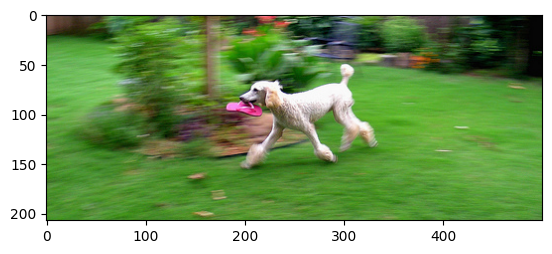

In [27]:
random_image_filepath = df['image_path'].sample(1).to_list()[0]
p_image = plt.imread(str(random_image_filepath))

cap = df.filter(df['image_path']==random_image_filepath)
img_cap = cap['caption'].to_list()

plt.imshow(p_image)

for i, cap in enumerate(img_cap):
    print(i , ' : ', cap)



## Finding Rare Words

In [28]:
def word_count_df(x:pl.series):
    words = set(x)

    word_list = []
    for sentence in words:
        sentence = sentence.lower()
        words = sentence.split()
        word_list.extend(words)

    count_dict = Counter(word_list)

    return pl.DataFrame({'word':count_dict.keys(), 'counts':count_dict.values()})



In [29]:
countdf = word_count_df(df['caption'])
print('unique words: ',countdf.shape)

unique words:  (8778, 2)


In [30]:
countdf=countdf.with_columns(
        pl.col('word').apply(lambda x : len(x)).alias('word_len')
)

display(countdf.filter(countdf['word_len']==1)) # these are single letter words. (do not add much detail. will remove in tokenizing step)

word,counts,word_len
str,i64,i64
"""a""",62635,1
"""s""",403,1
"""c""",1,1
"""i""",16,1
"""x""",3,1
"""v""",2,1
"""n""",4,1
"""o""",4,1
"""u""",3,1


In tokenizing part we will remove single characters like a, i , c, m 

In [31]:
# just for fun lets see the longest words in captions
countdf.sort('word_len', descending=True).head(20)

word,counts,word_len
str,i64,i64
"""horizontallyst…",1,19
"""extravagantlyh…",1,19
"""saltandpepperh…",1,19
"""endorsementcov…",1,18
"""budweiserspons…",1,18
"""japanesesponso…",1,17
"""enthusiastical…",2,16
"""butterflycatch…",1,16
"""mountainclimbi…",1,16


these words has been joined without spaces that seems to have created new words. will fix it using `wordninja`

In [32]:
print(wordninja.split('i amgoing tomarket'))
print(' '.join(wordninja.split('i amgoing to market')))

['i', 'am', 'going', 'to', 'market']
i am going to market


In [33]:
df=df.with_columns(
    pl.col('caption').apply( lambda x: ' '.join(wordninja.split(x))).alias('caption')
)

In [34]:
# # again creating word_count_df

countdf2 = word_count_df(df['caption'])
print('unique words: ', countdf2.shape)

unique words:  (8129, 2)


In [35]:
8778-8129

649

We have removed ~650 words (8778-8129)

In [36]:
countdf2=countdf2.with_columns(
        pl.col('word').apply(lambda x : len(x)).alias('word_len')
)


In [37]:
# just for fun lets see the longest words in captions
countdf2.sort('word_len', descending=True).head(20)

word,counts,word_len
str,i64,i64
"""enthusiastical…",2,16
"""aerodynamicall…",1,15
"""transportation…",9,14
"""communications…",1,14
"""schoolchildren…",2,14
"""affectionately…",2,14
"""expressionless…",1,14
"""identification…",1,14
"""advertisements…",4,14


### High Frequency words

In [38]:
countdf2.sort(descending = True,by = 'counts').head(10)

word,counts,word_len
str,i64,i64
"""a""",62758,1
"""in""",18903,2
"""the""",18271,3
"""on""",10926,2
"""is""",9327,2
"""and""",9315,3
"""dog""",8000,3
"""with""",7754,4
"""man""",7240,3


In [39]:
words_1_freq = countdf2.filter(
        (countdf2['counts']==1)
)['word'].to_list()

print(f'{len(words_1_freq)} words just occured 1 times which is very rare given that there are ~40000 sentences ')
print()
print(words_1_freq[:100])

2898 words just occured 1 times which is very rare given that there are ~40000 sentences 

['attaches', 'entertains', 'impact', 'longhorns', 'reflects', 'armor', 'gingerbread', 'primping', 'snarl', 'cleared', 'strides', 'lifeguards', 'mucky', 'traveller', 'neither', 'beckham', 'patter', 'planked', 'panasonic', 'lo', 'transport', 'someplace', 'create', 'nest', 'spelunker', 'sewer', 'cornstalks', 'congratulate', 'sum', 'boo', 'chinatown', 'thinks', 'appa', 'rode', 'fairly', 'anticipation', 'lettuce', 'continues', 'sprinkles', 'maids', 'granite', 'ruin', 'windowed', 'chasse', 'berry', 'seller', 'cautious', 'caster', 'branding', 'cushions', 'include', 'chemical', 'warning', 'wain', 'disgusted', 'yerba', 'buena', 'repair', 'even', 'sh', 'ded', 'established', 'assemble', 'severe', 'rummage', 'weeping', 'willow', 'tor', 'spain', 'treed', 'closeout', 'rahi', 'daylight', 'unexcited', 'practising', 'solitude', 'beaks', 'grating', 'soo', 'mold', 'hs', 'irt', 'here', 'rim', 'dribbled', 'intensely'

there are just (~8100) words in total,
not dropping rare words, 

## Sent length distribution

In [40]:
df=df.with_columns(
    pl.col('caption').apply(lambda x: len(str(x).split(' '))).alias('sent_len')
)
df.head()

image_name,caption,image_path,comment_number,img_exists,sent_len
str,str,str,u32,bool,i64
"""1000268201_693…","""a child in a p…","""/kaggle/input/…",1,true,17
"""1000268201_693…","""a girl going i…","""/kaggle/input/…",2,true,7
"""1000268201_693…","""a little girl …","""/kaggle/input/…",3,true,8
"""1000268201_693…","""a little girl …","""/kaggle/input/…",4,true,9
"""1000268201_693…","""a little girl …","""/kaggle/input/…",5,true,12


<AxesSubplot: ylabel='count'>

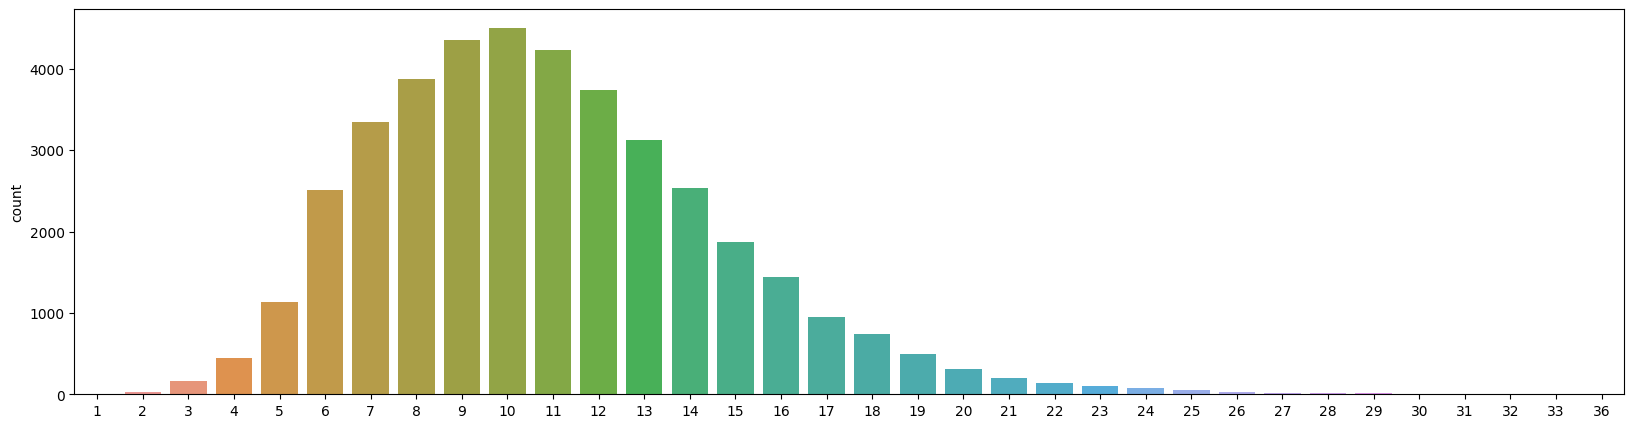

In [41]:
# plot sentence length
plt.figure(figsize=(20,5))
sns.countplot(x = df['sent_len'].to_list())

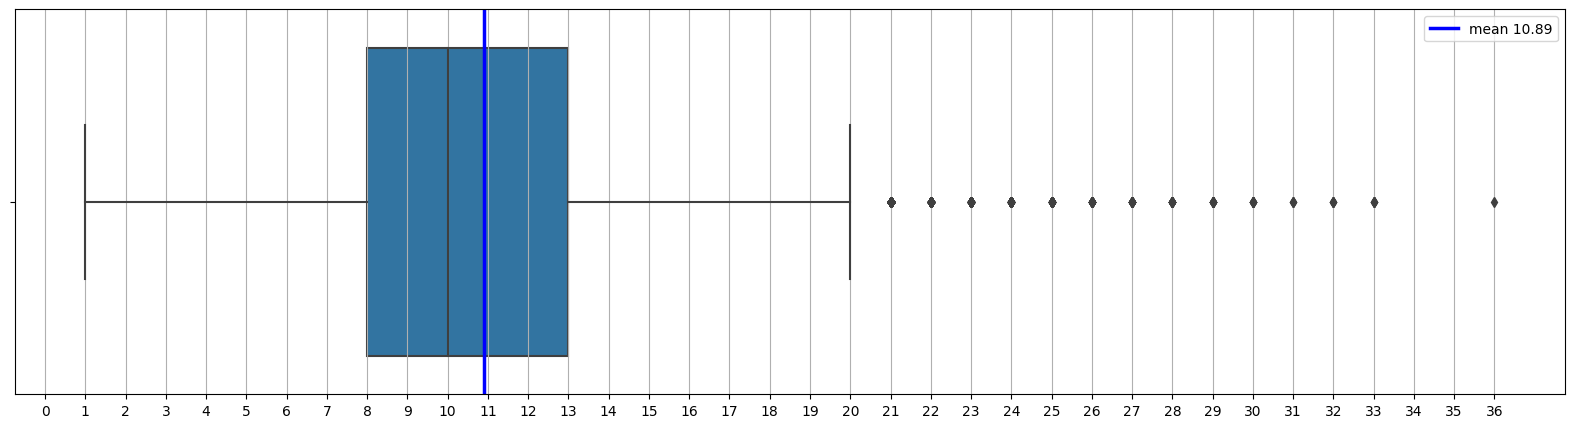

In [42]:
plt.figure(figsize=(20,5))
plt.grid(True)
sns.boxplot(x=df['sent_len'].to_list(), )
plt.axvline(x=df['sent_len'].mean(), color = 'blue', linewidth = 2.5, label=f"mean {df['sent_len'].mean():.2f}")
_ = plt.xticks(list(range(df['sent_len'].max()+1)))
plt.legend()

In [43]:

# Group by a categorical column
grouped = df.groupby('comment_number')

# Apply aggregation functions on numerical columns
aggregated = grouped.agg(
    pl.col('sent_len').mean().alias('mean'), 
    pl.col('sent_len').median().alias('median'), 
    pl.col('sent_len').min().alias('min'), 
    pl.col('sent_len').max().alias('max'), 
    pl.col('sent_len').count().alias('count')
)
aggregated

comment_number,mean,median,min,max,count
u32,f64,f64,i64,i64,u32
2,11.065752,11.0,2,33,8091
4,10.657397,10.0,2,32,8091
3,10.838957,10.0,2,30,8091
5,10.66024,10.0,2,36,8091
1,11.247188,11.0,1,33,8091


I wonder how caption with one word is describing a picture

In [44]:
min_len_limit = 3
small_captions = df.filter(pl.col('sent_len')<min_len_limit)['caption'].to_list()
small_captions_len = df.filter(pl.col('sent_len')<min_len_limit)['sent_len'].to_list()

for cap, cap_len in zip(small_captions, small_captions_len):
    print(f'{cap_len}:{cap}')
    

2:two skateboarders
2:dogs racing
2:four children
1:a
2:people walking
2:dog yawns
2:dogs playing
2:broken image
2:trucks racing
2:man surfing
2:rugby match
2:a basketball
2:dog barking
2:a skier
2:two dogs
2:man skateboarding
2:men skiing
2:cheerleaders perform
2:concentration campsite
2:police gather
2:asian spectators
1:a
2:javelin competition
2:a cyclist
2:rocky mountains


There are 2 picture with caption 'A' 🤣. Sometimes i look at pictures and describe it as 'A'. (will dropp those based on sent_length)

## Adding start and end token


In [45]:
# Adding start and end token
df = df.with_columns([
    pl.col("caption").apply(lambda x: START_TOKEN + ' '+ x +' '+ END_TOKEN).alias('caption'),
])



In [46]:
display(df.head())

image_name,caption,image_path,comment_number,img_exists,sent_len
str,str,str,u32,bool,i64
"""1000268201_693…","""startseq a chi…","""/kaggle/input/…",1,true,17
"""1000268201_693…","""startseq a gir…","""/kaggle/input/…",2,true,7
"""1000268201_693…","""startseq a lit…","""/kaggle/input/…",3,true,8
"""1000268201_693…","""startseq a lit…","""/kaggle/input/…",4,true,9
"""1000268201_693…","""startseq a lit…","""/kaggle/input/…",5,true,12


## Selecting sent length >=2

In [47]:
min_sent_len = 2 # this logic still works because we created sent_len before adding start and end token and is unchanged

In [48]:
df = df.filter(
     (pl.col("sent_len") <= MAX_LEN) & (pl.col("sent_len") >= min_sent_len) #& (pl.col("comment_number") == 1)  #& (pl.col("img_exists") == True) 
)
print(df.shape)
df.head()

(40453, 6)


image_name,caption,image_path,comment_number,img_exists,sent_len
str,str,str,u32,bool,i64
"""1000268201_693…","""startseq a chi…","""/kaggle/input/…",1,true,17
"""1000268201_693…","""startseq a gir…","""/kaggle/input/…",2,true,7
"""1000268201_693…","""startseq a lit…","""/kaggle/input/…",3,true,8
"""1000268201_693…","""startseq a lit…","""/kaggle/input/…",4,true,9
"""1000268201_693…","""startseq a lit…","""/kaggle/input/…",5,true,12


In [49]:
# just checking
print(df.filter(df['sent_len']==2)['caption'].to_list()[:10])

['startseq two skateboarders endseq', 'startseq dogs racing endseq', 'startseq four children endseq', 'startseq people walking endseq', 'startseq dog yawns endseq', 'startseq dogs playing endseq', 'startseq broken image endseq', 'startseq trucks racing endseq', 'startseq man surfing endseq', 'startseq rugby match endseq']


In [50]:
# saving the cleaned df 
df.write_csv('cleaned_df.csv')

In [51]:
df = pl.read_csv('cleaned_df.csv')

In [52]:
df.shape

(40453, 6)

# Tokenize

In [53]:
def preprocess_text(text):

    text = tf.strings.lower(text)

    text = tf.strings.regex_replace(text, r'\d', '')

    # Remove any punctuations
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(
        '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), '')

    # Remove single characters
    text = tf.strings.regex_replace(text, r'\b\w\b', '')
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿|]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    return text

In [54]:

#tokenizer
tokenizer = TextVectorization(standardize=preprocess_text)
tokenizer.adapt(df['caption'].to_list())


word_to_id = tf.keras.layers.StringLookup(vocabulary=tokenizer.get_vocabulary(), mask_token='', oov_token='[UNK]')
id_to_word = tf.keras.layers.StringLookup(vocabulary=tokenizer.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)


In [55]:
ss = tokenizer(['hey , how is  your dead grandma'])
ss

<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[   1, 1339,    7,    1, 1101,    1]])>

In [56]:
id_to_word(ss)

<tf.Tensor: shape=(1, 6), dtype=string, numpy=
array([[b'[UNK]', b'how', b'is', b'[UNK]', b'dead', b'[UNK]']],
      dtype=object)>

here, `'hey'` and `'grandma'` turned into `'[UNK]'` token , because it was never seen in the data. on which `tokenizer` is adapted.
(`Tokenizer` flagges unknown token as `'[UNK]'` )

# making Dataset

In [57]:

def mapper(x, y, tokenizer):
    '''
    this function maps load image function to images and tokenizes strings and splits them into txt_in 
    for decoder and txt_out as y by sifting one position right
    '''

    
    # Load images using the helper function
    x = load_images_now(x)
    
    # Tokenize the input sequence using the provided tokenizer
    y = tokenizer(y)
    
    # Prepare the input sequence (y_in) for the model
    y_in = y[:-1]  # Extract all elements of y except the last one
    y_in = tf.pad(y_in, [[0, MAX_LEN - tf.shape(y_in)[0]]], constant_values=0)
    # Pad y_in with zeros to make its length equal to MAX_LEN
    
    # Prepare the output sequence (y_out) for the model
    y_out = y[1:]  # Extract all elements of y except the first one
    y_out = tf.pad(y_out, [[0, MAX_LEN - tf.shape(y_out)[0]]], constant_values=0)
    # Pad y_out with zeros to make its length equal to MAX_LEN
    
    # Return the input tuple (x, y_in) and the output y_out
    return (x, y_in), y_out


@tf.function
def load_images_now(x):
    # Read the image file data
    image_data = tf.io.read_file(x)
    
    # Decode the JPEG image and specify the number of color channels
    image_features = tf.image.decode_jpeg(image_data, channels=CHANNELS)
    
    # Resize the image to a specific size
    image_features = tf.image.resize(image_features, (IMG_SIZE, IMG_SIZE))
    
    # Normalize the image features by dividing by 255
    return image_features / 255


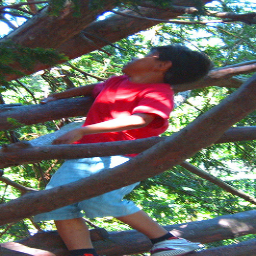

In [58]:
random_image_filepath = df['image_path'].sample(1).to_list()[0]
p_image = load_images_now(str(random_image_filepath))
array_to_img(p_image)


In [59]:
p_image.shape

TensorShape([256, 256, 3])

In [60]:
# Creating dataset split for train, test and val
TEST_SIZE = config['test_size']
VAL_SIZE =  config['val_size']

train, val = train_test_split(
    df[['image_path', 'caption']],  test_size=VAL_SIZE, random_state=14)
train, test = train_test_split(
    train[['image_path', 'caption']],  test_size=TEST_SIZE, random_state=14)


In [61]:
# tf.data.Dataset
train_data = tf.data.Dataset.from_tensor_slices((train['image_path'].to_list(), train['caption'].to_list()))
test_data = tf.data.Dataset.from_tensor_slices((test['image_path'].to_list(), test['caption'].to_list()))
val_data = tf.data.Dataset.from_tensor_slices((val['image_path'].to_list(), val['caption'].to_list()))


train_data = train_data.map(lambda x,y:mapper(x, y, tokenizer)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data =   test_data.map(lambda x,y:mapper(x, y, tokenizer)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data =     val_data.map(lambda x,y:mapper(x, y, tokenizer)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [62]:

print("Number of training samples: %d" %
      tf.data.experimental.cardinality(train_data))
print("Number of validation samples: %d" %
      tf.data.experimental.cardinality(val_data))
print("Number of test samples: %d" %
      tf.data.experimental.cardinality(test_data))

VOCAB_SIZE = tokenizer.vocabulary_size()
print("Vocabulary size: %d" % VOCAB_SIZE)


Number of training samples: 1141
Number of validation samples: 64
Number of test samples: 61
Vocabulary size: 8109


In [63]:
for (img_in, txt_in), txt_out in train_data.take(1):
    # print(f'{i.numpy().decode():<40} {j.numpy()}')
    print('x     : ', img_in.shape)
    print('y_in.shape(one batch)  : ', txt_in.shape)
    
    print('y_in  : ', txt_in[0])
    
    print('y_out.shape(one batch)  : ', txt_out.shape)
    print('y_out : ', txt_out[0])
    print('\n')


x     :  (32, 256, 256, 3)
y_in.shape(one batch)  :  (32, 40)
y_in  :  tf.Tensor(
[  2 122  23 255 905 274   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int64)
y_out.shape(one batch)  :  (32, 40)
y_out :  tf.Tensor(
[122  23 255 905 274   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int64)




# Model

We will use resnetV2 for image feature extraction

In [64]:
resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
)
resnet.trainable=False
resnet.compile() # you have to complie it after setting it to non-trainable

94668760/94668760 [==============================] - 4s 0us/step


In [65]:
# shape check
mob_test = resnet(p_image[tf.newaxis,...])
mob_test.shape

TensorShape([1, 8, 8, 2048])

## Image encoder

In [66]:
class ImageEncoder(tf.keras.layers.Layer):
    def __init__(self, feature_extractor, units, embedding_dims):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.embedding_dims = embedding_dims
        self.dense = Dense(embedding_dims)
        self.context_dense = Dense(units)
        self.flatten = Flatten()
        self.batch_norm = BatchNormalization()
        
    def call(self, x, return_state=False):
        batch_size = tf.shape(x)[0]
        
        x = self.feature_extractor(x)
            
        '''
        the idea here is to give decoder something to think about image 
        as a initial state in the beginning,  instead of just random initialized state. 
        so here we are trying to make
        two tensors of shape [batch, units] as hidden_state and cell_state and pass it to decoder rnn.
        '''
        x_dense = self.dense(x)
    
        h = self.context_dense(self.flatten(x_dense))
        h = self.batch_norm(h)
        c = self.context_dense(self.flatten(x_dense))
        c = self.batch_norm(c)
        img_state = [h,c]
        
    
        '''
        reshaping extracted features (x) to match shape for attention with rnn outputs
        '''
        x_reshaped = tf.reshape(x, (batch_size, -1, self.embedding_dims)  ) 
        
        if return_state:
            return x_reshaped, img_state
        else:
            return x_reshaped

In [67]:
# shape check
img_encoded = ImageEncoder(resnet,units = 8, embedding_dims=32)
img_encoded,img_state= img_encoded(img_in, return_state=True)
img_encoded.shape, [i.shape for i in img_state]

(TensorShape([32, 4096, 32]), [TensorShape([32, 8]), TensorShape([32, 8])])

## Decoder

In [68]:
class Decoder(tf.keras.layers.Layer):
    
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun
    
    def __init__(self, units, tokenizer, embedding_dims, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.units = units
        self.tokenizer =tokenizer
        self.embedding_dims = embedding_dims 
        self.start_token = START_TOKEN
        self.end_token = END_TOKEN
        
        self.embedding = Embedding(input_dim=tokenizer.vocabulary_size(), output_dim = embedding_dims, mask_zero=True)
        self.rnn = LSTM(self.units, return_state =True, return_sequences=True)
        self.mha = MultiHeadAttention(num_heads = 4, key_dim = embedding_dims, dropout = dropout_rate)
        self.dense = Dense(tokenizer.vocabulary_size(), activation='softmax')
        self.last_attention_weights = None
        self.word_to_id = tf.keras.layers.StringLookup(vocabulary=tokenizer.get_vocabulary(), mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(vocabulary=tokenizer.get_vocabulary(),mask_token='', oov_token='[UNK]',invert=True)
        self.start_token_id = tokenizer(START_TOKEN)
        self.end_token_id = tokenizer(END_TOKEN)
        self.dropout_layer = Dropout(dropout_rate)
        
    def call(self, x, context, state=None, return_state=False):
        
        x = self.embedding(x)

        x, h,c = self.rnn(x, initial_state=state)
        state=[h, c]
#         x = self.dropout_layer(x)
        
        # Attention
        attention, weights = self.mha(x, context, return_attention_scores=True)
        self.last_attention_weights = weights

#         x = self.dropout_layer(x)
        x = Concatenate()([x, attention])
#         x = self.dropout_layer(x)
        x = self.dense(x)
        

        if return_state:
            return x, state
        else:
            return x
        

In [69]:
# shape check
dec = Decoder(UNITS, tokenizer, D_MODEL)
dec_out, dec_state = dec(txt_in, img_encoded, return_state=True)
dec_out.shape, [i.shape for i in dec_state]

(TensorShape([32, 40, 8109]), [TensorShape([32, 32]), TensorShape([32, 32])])

## Main Model

In [70]:
class Captioner(tf.keras.Model):

    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun
    
    def __init__(self, tokenizer, units, embedding_dims, feature_extractor, dropout_rate = 0.1):
        super().__init__()

        self.image_encoder = ImageEncoder(feature_extractor=feature_extractor, units=units, embedding_dims=embedding_dims)
        self.decoder = Decoder(units=units, tokenizer=tokenizer, embedding_dims=embedding_dims,  dropout_rate=dropout_rate)
        
    def call(self, inputs, return_state=False):
        
        img_in, txt_in = inputs
        
        img,img_state = self.image_encoder(img_in, return_state=True)
        x = self.decoder(x = txt_in,context=img, state=img_state)

        return x


In [71]:
model = Captioner(tokenizer,units = UNITS, embedding_dims = D_MODEL, feature_extractor=resnet, dropout_rate=0.1)

In [72]:
# shape check
out =  model((img_in, txt_in))
print('output shape: ',out.shape)

output shape:  (32, 40, 8109)


In [73]:
model.summary()

Model: "captioner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_encoder_1 (ImageEncod  multiple                 24613792  
 er)                                                             
                                                                 
 decoder_1 (Decoder)         multiple                  3232909   
                                                                 
Total params: 27,846,701
Trainable params: 4,281,837
Non-trainable params: 23,564,864
_________________________________________________________________


### Custom accuracy and loss

In [74]:

def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( #from_logits=True,
        reduction='none')
    loss = loss_fn(y_true, y_pred)

    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

def masked_accuracy(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = y_true == y_pred

    mask = y_true != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [75]:
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [76]:
model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])



In [77]:
!ls 'saved_weights'

ls: cannot access 'saved_weights': No such file or directory


In [78]:
try:
    model.load_weights('saved_weights/rnn1') # if no saved weights then pass
except:
    pass

In [79]:
EPOCHS = 10

steps_per_epoch = 300
validation_steps = 3

print(steps_per_epoch, validation_steps)


300 3


In [80]:
{'vocab_size':VOCAB_SIZE,
"expected_loss": np.log(VOCAB_SIZE),
 "expected_acc": 1/VOCAB_SIZE}

{'vocab_size': 8109,
 'expected_loss': 9.000729834944558,
 'expected_acc': 0.00012331976815883587}

## model.fit

In [81]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="masked_accuracy",
    min_delta=0,
    patience=7,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [82]:
callbacks = [earlystopping]

In [83]:
EPOCHS = 100

In [84]:
if TRAIN:
    history = model.fit(train_data.repeat(),
                        epochs=EPOCHS,
                        validation_data=val_data,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps,
                        callbacks = callbacks
                        )
    
    model.save_weights('saved_weights/rnn1')
else:
#     model.evaluate(test_data)
    pass

Epoch 1/100
300/300 [==============================] - 93s 269ms/step - loss: 4.8896 - masked_accuracy: 0.2095 - val_loss: 4.3768 - val_masked_accuracy: 0.2637
Epoch 2/100
300/300 [==============================] - 55s 184ms/step - loss: 4.2122 - masked_accuracy: 0.2655 - val_loss: 4.2305 - val_masked_accuracy: 0.2627
Epoch 3/100
300/300 [==============================] - 49s 165ms/step - loss: 4.1426 - masked_accuracy: 0.2712 - val_loss: 4.3833 - val_masked_accuracy: 0.2667
Epoch 4/100
300/300 [==============================] - 47s 157ms/step - loss: 4.2952 - masked_accuracy: 0.2652 - val_loss: 4.2302 - val_masked_accuracy: 0.2677
Epoch 5/100
300/300 [==============================] - 48s 160ms/step - loss: 4.0255 - masked_accuracy: 0.2788 - val_loss: 4.0558 - val_masked_accuracy: 0.2887
Epoch 6/100
300/300 [==============================] - 47s 157ms/step - loss: 4.2189 - masked_accuracy: 0.2785 - val_loss: 4.1887 - val_masked_accuracy: 0.2637
Epoch 7/100
300/300 [===================

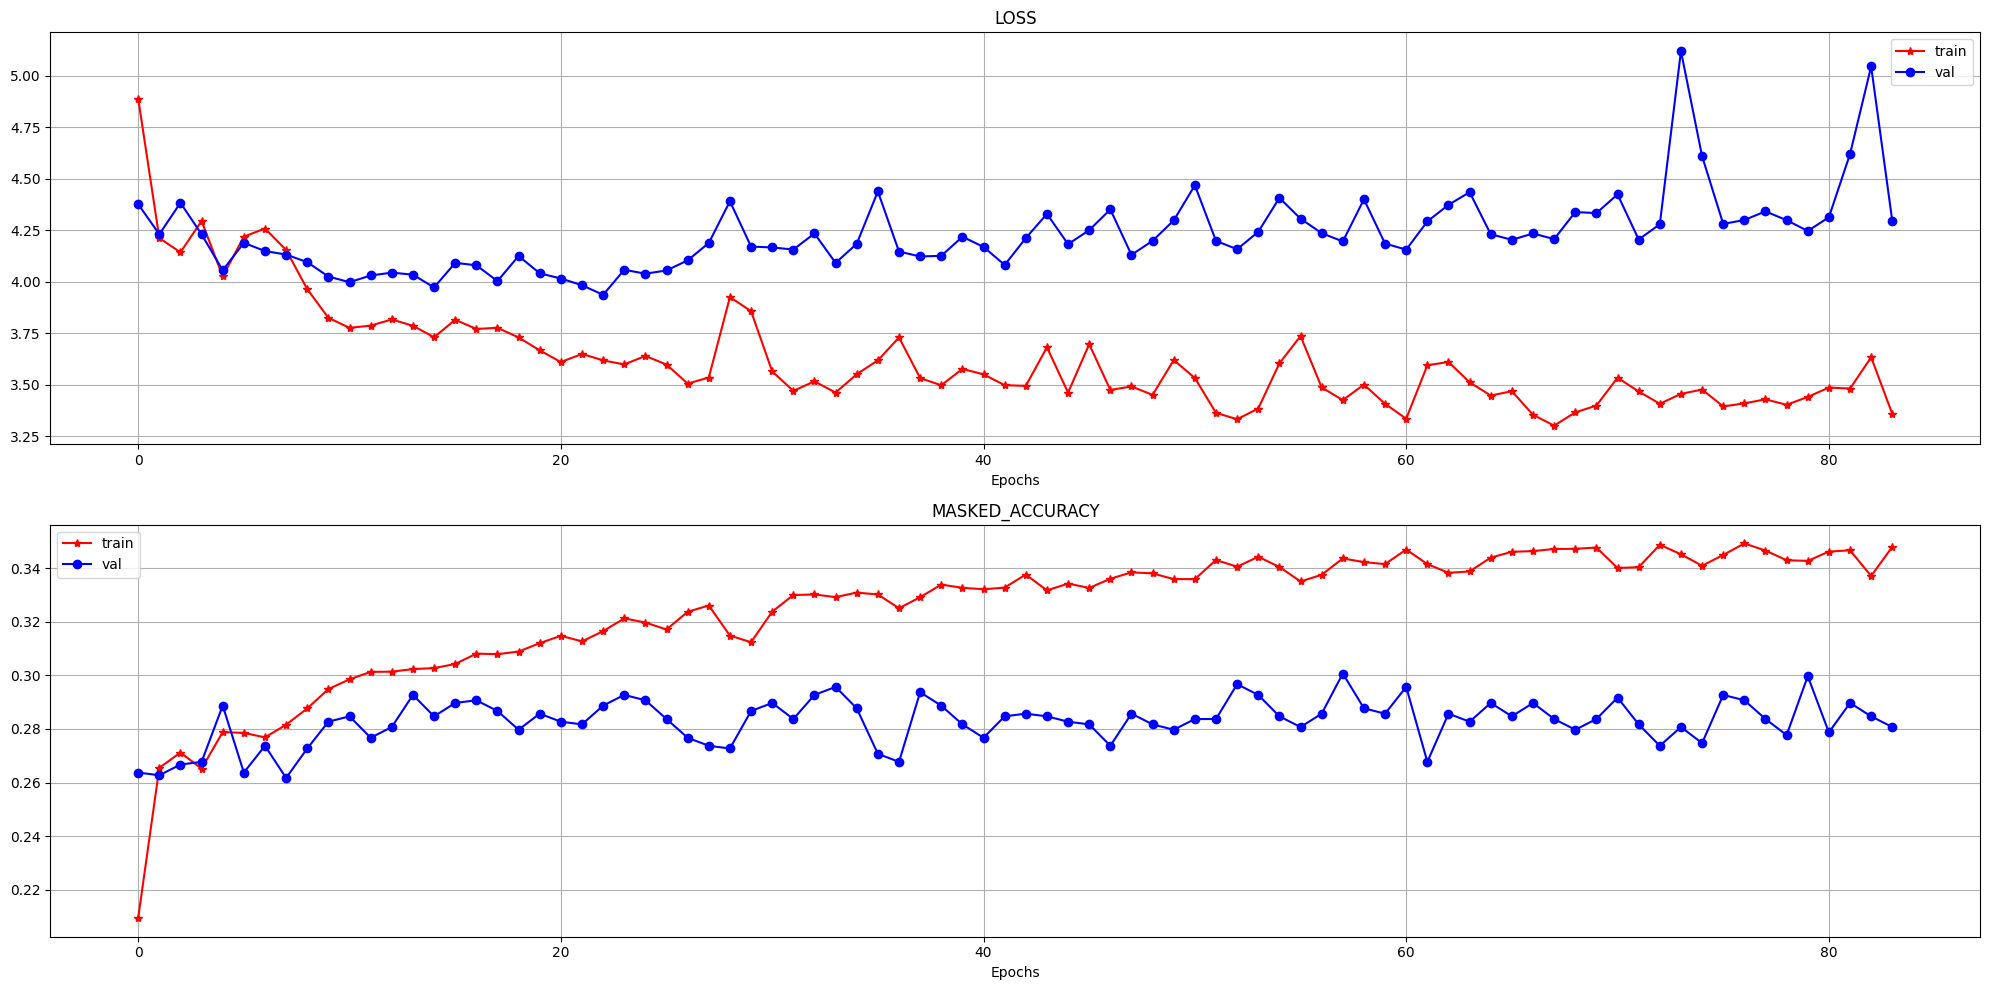

In [85]:
if TRAIN:
    plt.figure(figsize = (20, 10))

    plt.subplot(2,1,1)
    plt.grid(True)
    plt.plot(history.history['loss'], marker = '*', color='red', label = 'train')
    plt.plot(history.history['val_loss'], marker = 'o', color = 'blue', label = 'val')
    plt.xlabel('Epochs')
    plt.title('LOSS')
    plt.legend()

    
    plt.subplot(2,1,2)
    plt.grid(True)
    plt.plot(history.history['masked_accuracy'], marker = '*', color='red', label = 'train')
    plt.plot(history.history['val_masked_accuracy'], marker = 'o', color='blue', label = 'val')
    plt.xlabel('Epochs')
    plt.title('MASKED_ACCURACY')
    
    plt.legend()
    
    plt.tight_layout()

In [86]:
# model.evaluate(test_data)

# Inference

In [87]:
for (imga, txin), txout in test_data.take(1):
    print(imga.shape)
    print(txin.shape)
    print(txout.shape)
    print(' ')
    break

(32, 256, 256, 3)
(32, 40)
(32, 40)
 


In [88]:
@Decoder.add_method
def get_initial_state(self,k):
    start_tokens = tf.fill([k,1], self.tokenizer(self.start_token))
    return start_tokens

@Decoder.add_method
def tokens_to_text1(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *startseq *', '')
    result = tf.strings.split(result, sep='endseq', maxsplit = 1).numpy()
    result = result[:,0]
    result = [string.decode('utf-8') for string in result]
    return result

@Decoder.add_method
def tokens_to_text2(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *startseq *', '')  
    result = tf.strings.regex_replace(result, ' *endseq *$', '')   #' *endseq *$'
    result = [string.decode('utf-8') for string in result.numpy()]
    return result

# Inference with BEAM SEARCH

In [89]:
@Captioner.add_method
def gen(self,
            img, k=3,
            max_length=50,
            norm_factor = 0.9,
            temperature=0.0):
    
    # Process the input image
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    if img.ndim==3:
        img=tf.broadcast_to(img, (k,)+img.shape)
        
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    x_img, state = self.image_encoder(img, return_state=True)

    batch_size = tf.shape(img)[0]

    # Setup the loop inputs
    tokens = None
    bscore = None
    next_token = self.decoder.get_initial_state(k)

    
    for i in range(max_length+1):
        logits, state = self.decoder(x=next_token, context=x_img, state=state, return_state=True)

        if temperature != 0.0 :
            '''
            if temperature is not 0 then picking random values after dividing logits with temperature
            '''
            logits = logits/temperature 
            kword = tf.random.categorical(logits[:,-1,:], num_samples=k)
            sim_logits = tf.squeeze(logits[:,-1,:])
            kprob = tf.gather(sim_logits, kword, axis=1, batch_dims=1)

        else:
        
            # top k word
            '''
            else picking top k words and their probability
            '''
            kprob, kword = tf.math.top_k(logits[:,-1,:], k = k)

        if i == 0:
            
            '''
            for first run we are append all three words of one prediction to tokens  as  all k batch startseq produces  same results
            '''
            tokens = tf.reshape(kword[0,:],(k,-1)).numpy()
            next_token = np.copy(tokens)
            bscore = tf.reshape(kprob[0,:], (k,-1)).numpy()
            
        else:
            
            '''
            for other runs first we repeat tokens (k times) then flatten the predicted tokens and add it to tokens as new_captions
            '''
            br_tokens = tf.repeat(next_token,k,axis = 0)
            new_captions = tf.concat([br_tokens, tf.reshape(kword, (k*k,1))], axis = -1)
            
            '''
            same with beam score
            '''
            br_bscore = tf.repeat(bscore,k,axis = 0)
            concat_beam_score = tf.concat([br_bscore, tf.reshape(kprob, (k*k,1))], axis = -1)
            n_words= concat_beam_score.shape[-1] # number os words in tokens predicted yet

            '''
            here we calculate log of probabilities then add them and finally dividing it by number of words to average it(why?)
            norm factor is a adjustment nob to control how much nomalization is needed.
            
            WATCH ANDREW NG EXPLAINING 
            TOPIC : REFINING BEAM SEARCH , 
            URL : https://youtu.be/gb__z7LlN_4
            '''
            log_main_prob = tf.reduce_sum(tf.math.log(concat_beam_score),axis = 1)/n_words**norm_factor
            top_k_values, top_k_indices  = tf.math.top_k(log_main_prob, k = k)
            
            
            #grabbing top_k_indices values from bscore and newcaptions
            selected_tokens = tf.gather(new_captions, top_k_indices)
            selected_bscore = tf.gather(concat_beam_score, top_k_indices)
            
            # appending selected words
            tokens[:,i-1] = selected_tokens[:,i-1]
            tokens= np.concatenate((tokens,tf.reshape(selected_tokens[:,i],(k,1))), axis = -1)
            
            next_token = np.copy(tokens)
            
            '''
            Here not only we are appending only next token but also editing curent token based of log_probability
            '''
            # appending selected probs
            bscore[:,i-1] = selected_bscore[:,i-1]
            bscore= np.concatenate((bscore,tf.reshape(selected_bscore[:,i],(k,1))), axis = -1)

            
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    try:
        result = self.decoder.tokens_to_text1(tokens)
    except:
        result = self.decoder.tokens_to_text2(tokens)
    return result

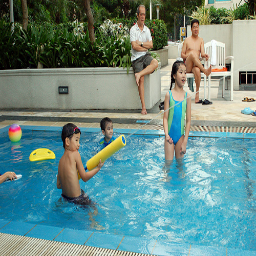

['little boy in swim trunks jumping into the water ']

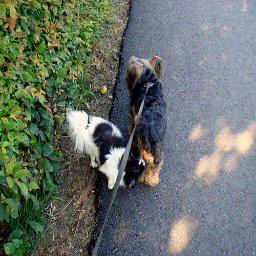

['black and white dog are playing with red ball in the background ']

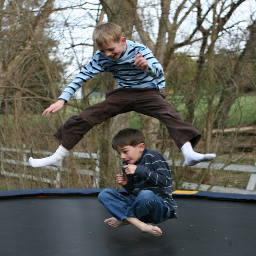

['two little girls in bathing suit and gold clothing are playing basketball ']

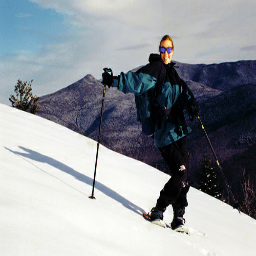

['woman in red jacket is skiing ']

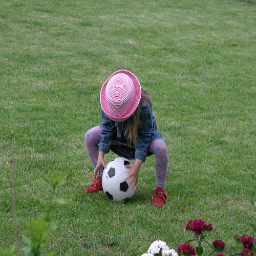

['little girl in red shirt is dribbling the ball in the background ']

In [90]:
# random_image_filepath = test['image_path'].sample(1).to_list()[0]
p_image = load_images_now(str(test['image_path'].sample(1).to_list()[0]))


temp = 0
norm_factor = 1
k = 1    
    
    
for i in range(5):
    random_image_path = str(test['image_path'].sample(1).to_list()[0])
    p_image = load_images_now(random_image_path)

    
    print()
    result = model.gen(p_image, k=k,max_length=15, norm_factor=norm_factor, temperature =temp ) 
    display(array_to_img(p_image),result)


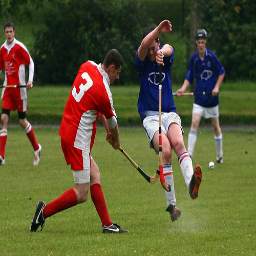

['three basketball players are baseball cricket the ocean ',
 'two men players in playing in field water water ',
 'three men players in playing in the ']

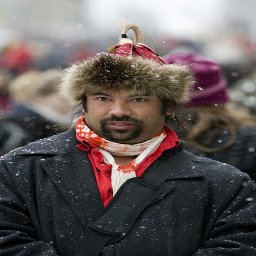

['man in is scaling down the grass ',
 'black in is walking down the grass ',
 'man dog is walking along the grass ']

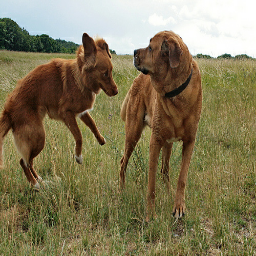

['two brown dogs are running with the grass in field background cracked peak ',
 'two dogs are play playing with the field ',
 'two dogs dogs are playing in the grass in the ']

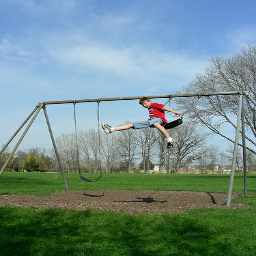

['little boy is shirt and swinging on his ',
 'boy boy red shirt is swinging on tripod ',
 'boy in is shirt is swinging on his ']

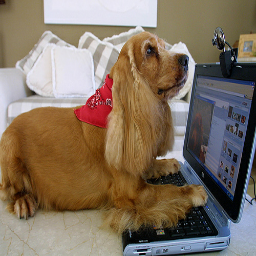

['brown dog is jumping from the ground ',
 'dog dog is jumping over the water ',
 'small dog is jumping over the ground ']

In [91]:
# random_image_filepath = test['image_path'].sample(1).to_list()[0]
p_image = load_images_now(str(test['image_path'].sample(1).to_list()[0]))


temp = 0
norm_factor = 1
k = 3
    
    
for i in range(5):
    random_image_path = str(test['image_path'].sample(1).to_list()[0])
    p_image = load_images_now(random_image_path)

    
    print()
    result = model.gen(p_image, k=k,max_length=15, norm_factor=norm_factor, temperature =temp ) 
    display(array_to_img(p_image),result)


## Saving the Model

In [92]:
random_image_filepath = df['image_path'].sample(1).to_list()[0]
p_image = load_images_now(str(random_image_filepath))


In [93]:
tf.saved_model.save(model, 'caption_generator')

# Final Thoughts

We have seen repeatative caption being generating for some common objects in photos.
like if photo has dog it will say `['two dogs are playing in grass water ',
 'two dogs are running through the grass ',
 'two dogs in running the water water ',
 'two dogs run through the the water in the water in the water on its of ',
 'man people run playing the the ']
`

Which may be because 
* photo has more captions like this
* photos has not very explaining captions to map the contents of image to words of captions.


But till then. It works.